# Convolutional Neural Networks with Intermediate Loss for 3D Super-Resolution of CT and MRI Scans

This notebook is a replication/exploration of the paper listed above.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import sys
sys.path.append('..') # Stupid thing Python makes you do to import from a sibling directory
from gen_utils.SrGen import SrGen # Custom class for image generation

## Define model

In [46]:
class CNNIL(nn.Module):
    def __init__(self, upscale=2, axs = 'hw'):
        super().__init__()
        self.axs = axs

        self.rel = nn.ReLU()
        if axs == 'hw':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,4,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)
        elif axs == 'h' or axs == 'w':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,2,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)

    def forward(self, x):

        x = self.rel(self.conv1(x))
        
        x_l = self.rel(self.conv2(x))
        x_l = self.rel(self.conv3(x_l))
        x_l = self.rel(self.conv4(x_l+x))
        x_l = self.rel(self.conv5(x_l))
        x_l = self.rel(self.conv6(x_l+x))

        x_l = self.kern_upscale(x_l, axs = self.axs)

        x = self.rel(self.conv7(x_l))
        x_h = self.rel(self.conv8(x))
        x_h = self.rel(self.conv9(x_h))
        x_h = self.rel(self.conv10(x_h+x))

        return x_l, x_h #Return both results for the loss function

    @staticmethod
    def kern_upscale(x, axs='hw'):
        # Function to do the unique upscaling pattern they propose in
        # the paper
        #TODO: have them input a tuple for scale of the dimensions they wish to expand along
        s, c, h, w = [int(_) for _ in list(x.shape)]

        if axs == 'hw':
            c = int(c/2)
            x_up = torch.cat(torch.unbind(x,1),2)
            x_up = torch.reshape(x_up,(s,1,h*c,w*c))
            x_up = torch.transpose(x_up,2,3)
            x_up = torch.cat(torch.split(x_up,2,2),3)
            x_up = torch.transpose(torch.reshape(x_up,(s,1,h*c,w*c)),2,3)
        elif axs == 'h':
            x_up = torch.unsqueeze(torch.cat(torch.unbind(x,2),1),1)
            #x_up = torch.unsqueeze(x_up,0)
        elif axs == 'w':
            x_up = torch.cat(torch.unbind(x,3),1)
            x_up = torch.unsqueeze(torch.transpose(x_up,1,2),1)
            #x_up = torch.unsqueeze(x_up,0)
        else:
            print('No valid scaling dimension selected, returning False')
            x_up = False

        return x_up


In [2]:
# Testing of kern_upscale function with only 3D tensor

a = torch.tensor([[[1,2],[3,4]],
                [[5,6],[7,8]],
                [[9,10],[11,12]],
                [[13,14],[15,16]]])
a.shape

torch.Size([4, 2, 2])

In [3]:
# Concatinate each of the layers next to eachother
print(a.shape)
b = torch.cat(torch.unbind(a),1)
print(b.shape)
b = torch.reshape(b,(4,4))
print(b.shape)
b = torch.transpose(b,0,1)
b = torch.cat(torch.split(b,2,0),1)
torch.transpose(torch.reshape(b,(4,4)),0,1)

torch.Size([4, 2, 2])
torch.Size([2, 8])
torch.Size([4, 4])


tensor([[ 1,  5,  2,  6],
        [ 9, 13, 10, 14],
        [ 3,  7,  4,  8],
        [11, 15, 12, 16]])

In [4]:
# Testing of above kern_upscale function with 4D tensor (what the model will acually use)
a = torch.tensor([[[[1,2],[3,4]],
                [[5,6],[7,8]],
                [[9,10],[11,12]],
                [[13,14],[15,16]]]])
print(f'shape of a is {a.shape}')

b = torch.cat(torch.unbind(a,1),2)
b = torch.reshape(b,(1,1,4,4))
b = torch.transpose(b,2,3)
b = torch.cat(torch.split(b,2,2),3)
b = torch.transpose(torch.reshape(b,(1,1,4,4)),2,3)
b

shape of a is torch.Size([1, 4, 2, 2])


tensor([[[[ 1,  5,  2,  6],
          [ 9, 13, 10, 14],
          [ 3,  7,  4,  8],
          [11, 15, 12, 16]]]])

In [13]:
# Upscale along just one axis
a = torch.tensor([[[[1,2],[3,4]],
                [[5,6],[7,8]]],[[[2,4],[6,8]],[[10,12],[14,16]]]])
print(f'shape of a is {a.shape}')

# Version for doubling height
# b = torch.cat(torch.unbind(a,2),2)
# b = torch.reshape(b,(1,1,2,4))
# b = torch.cat(torch.split(b,2,3),2)

## b = torch.unsqueeze(torch.cat(torch.unbind(a,2),1),0)

# Version for doubling width
b = torch.cat(torch.unbind(a,3),1)
torch.unsqueeze(torch.transpose(b, 1,2),1)

#b.shape

shape of a is torch.Size([2, 2, 2, 2])


tensor([[[[ 1,  5,  2,  6],
          [ 3,  7,  4,  8]]],


        [[[ 2, 10,  4, 12],
          [ 6, 14,  8, 16]]]])

## Set Optimization Parameters

In [55]:
net_1 = CNNIL(axs = 'hw')
net_2 = CNNIL(axs = 'w')

# "... trained the CNN for 40 epochs, starting with a learning rate of 0.001 and decreasing
# the learning rate to 0.0001 after the first 20 epochs"
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(net_2.parameters(), lr=0.001)

# They have a custom loss function that incorporates the final results and the result
# right after the upscaling step
# https://discuss.pytorch.org/t/custom-loss-functions/29387

def intermediate_loss(output_intermediate, output_final, target):
    mae_loss = nn.L1Loss() #Built in mean absolute error loss function
    loss = mae_loss(output_intermediate, target)+mae_loss(output_final, target)
    return loss


## Generate Data for Training

In [41]:
sr_train_1 = SrGen('../data/CNNIL_nifti/Raw/','../data/CNNIL_nifti/HR_patches_ax/','../data/CNNIL_nifti/LR_patches_ax/')

temp = sr_train_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [10,10,2]
sr_train_1.set_template(temp)

# sr_train.run(clear=True, save=True)
sr_train_1.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


In [48]:
sr_train_2 = SrGen('../data/CNNIL_nifti/Raw/','../data/CNNIL_nifti/HR_patches_2/','../data/CNNIL_nifti/LR_patches_2/')
temp = sr_train_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
# temp['scale']= [1,1,1]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [2,20,20]
sr_train_2.set_template(temp)

# sr_train_2.run(clear=True, save=True)
sr_train_2.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


# Create Dataloader

In [49]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class, axs='hw'):
        self.sr_class = sr_class
        self.axs = axs

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)

        # SR along two axes
        if self.axs == 'hw':
            X = torch.unsqueeze(torch.squeeze(torch.tensor(X, dtype=torch.float32),-1),0)
            Y = torch.unsqueeze(torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1),0)

        # SR along one axis
        elif self.axs == 'h':
            X = torch.squeeze(torch.tensor(X, dtype=torch.float32),-1)
            Y = torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1)
        elif self.axs == 'w':
            raise NotImplementedError('Super resolution along width not currently supported')
        else:
            raise NotImplementedError(f'Super resolution along {self.axs} currently not supported')
            
        return X,Y

In [50]:
params = {'batch_size': 128,
        'shuffle': True,
        'num_workers': 3}

training_set = Dataset(sr_train_2, axs = 'h')
training_generator = torch.utils.data.DataLoader(training_set, **params)

# Training Loop

In [57]:
from tqdm import tqdm
import time

max_epochs = 20
save_rate = 10
epoch_adjust = 0
save_prefix = "./CNNIL_save_"

mean_loss = []

for epoch in tqdm(range(max_epochs)):
    losses = []

    ###### Test running this code where each epoch a new set of random images is made
    # sr_train.run(clear=True)

    # training_set = Dataset(sr_train)
    # training_generator = torch.utils.data.DataLoader(training_set, **params)
    ######


    # Training
    count = 0
    for inp, goal in training_generator:
        optimizer_2.zero_grad()

        output_1, output_2 = net_2(inp) # the 2 is the number of iterations in the LISTA network
        #output = torch.clamp(output, 0, 255)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_2.step()
        #print(f'loss = {loss.item()}')
        losses.append(loss.item())
        #print(f'mini-batch # {count}, mean loss = {sum(losses)/len(losses)}')
        count = count+1
    

    # if (epoch % save_rate == 0) or epoch == (max_epochs-1):
    #     torch.save(net.state_dict(), f'{save_prefix}{epoch+epoch_adjust}.p')
    print(f'\n epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}\n')
    mean_loss.append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


  0%|          | 0/20 [00:00<?, ?it/s]


 epoch 0, loss mean: 24.912885665893555, loss: 15.040494918823242-33.60326385498047



  5%|▌         | 1/20 [00:12<03:52, 12.22s/it]


 epoch 1, loss mean: 14.637580267588298, loss: 11.10688591003418-17.60952377319336



 10%|█         | 2/20 [00:25<03:54, 13.00s/it]


 epoch 2, loss mean: 10.707223828633627, loss: 9.399085998535156-12.473265647888184



 15%|█▌        | 3/20 [00:38<03:39, 12.94s/it]


 epoch 3, loss mean: 8.899015919367473, loss: 7.102175712585449-10.309595108032227



 20%|██        | 4/20 [00:52<03:30, 13.14s/it]


 epoch 4, loss mean: 7.801561673482259, loss: 5.87510871887207-8.834814071655273



 25%|██▌       | 5/20 [01:05<03:15, 13.06s/it]


 epoch 5, loss mean: 7.312359364827474, loss: 6.32581901550293-8.506750106811523



 30%|███       | 6/20 [01:17<03:02, 13.02s/it]


 epoch 6, loss mean: 7.236243979136149, loss: 6.256368637084961-10.29130744934082



 35%|███▌      | 7/20 [01:30<02:49, 13.01s/it]


 epoch 7, loss mean: 6.600006357828776, loss: 5.439182281494141-7.585395812988281



 40%|████      | 8/20 [01:43<02:35, 12.95s/it]


 epoch 8, loss mean: 6.333966286977132, loss: 5.639723300933838-7.310443878173828



 45%|████▌     | 9/20 [01:56<02:22, 12.96s/it]


 epoch 9, loss mean: 6.035986773173014, loss: 5.556248664855957-6.646017074584961



 50%|█████     | 10/20 [02:09<02:09, 12.96s/it]


 epoch 10, loss mean: 6.049953969319661, loss: 5.268136978149414-7.118051528930664



 55%|█████▌    | 11/20 [02:22<01:56, 12.93s/it]


 epoch 11, loss mean: 5.830224482218425, loss: 5.293516159057617-6.588449001312256



 60%|██████    | 12/20 [02:35<01:42, 12.87s/it]


 epoch 12, loss mean: 5.876652383804322, loss: 5.022849082946777-6.938161849975586



 65%|██████▌   | 13/20 [02:48<01:30, 12.86s/it]


 epoch 13, loss mean: 5.791742324829102, loss: 5.274097919464111-6.431184768676758



 70%|███████   | 14/20 [03:01<01:17, 12.91s/it]


 epoch 14, loss mean: 5.625034379959106, loss: 5.093735218048096-6.374768257141113



 75%|███████▌  | 15/20 [03:14<01:04, 13.00s/it]


 epoch 15, loss mean: 5.56691214243571, loss: 4.649538993835449-6.418514251708984



 80%|████████  | 16/20 [03:26<00:51, 12.89s/it]


 epoch 16, loss mean: 5.694764693578084, loss: 5.201357841491699-6.254780292510986



 85%|████████▌ | 17/20 [03:39<00:38, 12.82s/it]


 epoch 17, loss mean: 5.521954838434855, loss: 4.831023693084717-6.157052993774414



 90%|█████████ | 18/20 [03:51<00:25, 12.66s/it]


 epoch 18, loss mean: 5.607043838500976, loss: 4.9099507331848145-6.618631362915039



 95%|█████████▌| 19/20 [04:04<00:12, 12.54s/it]


 epoch 19, loss mean: 5.419387865066528, loss: 4.683772087097168-6.107345104217529



100%|██████████| 20/20 [04:16<00:00, 12.84s/it]


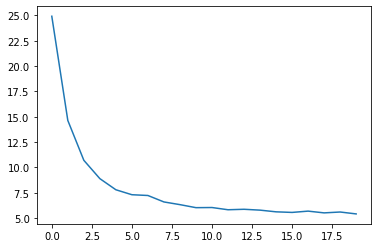

In [58]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
ax.plot([x for x in range(len(mean_loss))],mean_loss)

## Testing Model